In [2]:
# WRITTEN BY ALAN LI
# NASA AMES LABORATORY FOR ADVANCED SENSING (LAS)
# Last edited: Feb 1, 2018

import sys
sys.path.append("./utils/") # Adds higher directory to python modules path.
import random
import numpy as np
import cv2
import glob, os
from collections import Counter

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors
from collections import Counter
import pandas as pd
import logging
import yaml
from PIL import Image as pil_image

import tensorflow as tf
from tensorflow.python.client import device_lib
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import loadcoraldata_utils as coralutils
import keras
import keras.backend as K
from keras.models import Model, Sequential, load_model
from keras.utils import np_utils
from keras import optimizers
from keras.preprocessing.image import img_to_array
from keras.callbacks import Callback
from NeMO_models import FCN
import NeMO_layers
import NeMO_encoders
from NeMO_generator import NeMOImageGenerator, ImageSetLoader
from NeMO_callbacks import CheckNumericsOps, WeightsSaver

num_cores = 4
num_GPU = 1
num_CPU = 1

global _SESSION
config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU})
_SESSION = tf.Session(config=config)
K.set_session(_SESSION)

%matplotlib notebook

model = load_model('./tmp/VGG16DeepLab_Raster256.h5', custom_objects={'BilinearUpSampling2D':NeMO_layers.BilinearUpSampling2D})

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
<class 'keras.engine.training.Model'>
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [3]:
# Test export of patches from gdal
imgpath = '../Images/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tif'
tfwpath = '../Images/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI/BTPB-WV2-2012-15-8Band-mosaic-GeoTiff-Sample-AOI.tfw'
truthpath = '../Images/BIOT-PerosBanhos-sample-habitat-map/BIOT-PerosBanhos-sample-habitat-map.shp'
output_trainpath = '../Images/LO_Training_Patches/'
output_trainrefpath = '../Images/LO_TrainingRef_Patches/'
output_trainfilename = 'rastertrain.txt'
output_validpath = '../Images/LO_Valid_Patches/'
output_validrefpath = '../Images/LO_ValidRef_Patches/'
output_validfilename = 'rastervalid.txt'

PerosBanhos = coralutils.CoralData(imgpath, Truthpath=truthpath, load_type="raster", tfwpath=tfwpath)

with open("init_args - VGG16DeepLab_Raster256.yml", 'r') as stream:
    try:
        init_args = yaml.load(stream)
    except yaml.YAMLError as exc:
        print(exc)

train_loader = ImageSetLoader(**init_args['image_set_loader']['train'])
val_loader = ImageSetLoader(**init_args['image_set_loader']['val'])

if train_loader.color_mode == 'rgb':
    num_channels = 3
elif train_loader.color_mode == '8channel':
    num_channels = 8
y = train_loader.target_size[1]
x = train_loader.target_size[0]

pixel_mean =1023.5*np.ones(num_channels)
pixel_std = 1023.5*np.ones(num_channels)
datagen = NeMOImageGenerator(image_shape = (y,x,num_channels),
    image_resample=True, pixelwise_center=True,
    pixel_mean=pixel_mean, pixelwise_std_normalization=True,
    pixel_std=pixel_std)

train_generator = datagen.flow_from_NeMOdirectory(output_trainpath,
    target_size=(y,x),
    color_mode='8channel',
    classes = PerosBanhos.class_labels,
    class_mode = 'categorical',
    batch_size = 120,
    shuffle=True)

PerosBanhos.load_PB_consolidated_classes()

Found 0 images belonging to 24 classes, split into 24 consolidated classes.


{'NoData': 0, 'back reef - pavement': 1, 'back reef - rubble dominated': 2, 'back reef - sediment dominated': 3, 'back reef coral framework': 4, 'Beach': 5, 'Clouds': 6, 'coralline algal ridge (reef crest)': 7, 'deep fore reef slope': 8, 'deep lagoonal water': 9, 'deep ocean water': 10, 'dense seagrass meadows': 11, 'fore reef sand flats': 12, 'Inland waters': 13, 'lagoonal floor - barren': 14, 'lagoonal fringing reefs': 15, 'lagoonal patch reefs': 16, 'lagoonal sediment apron - sediment dominated': 17, 'mangroves': 18, 'Rocky beach': 19, 'shallow fore reef slope': 20, 'shallow fore reef terrace': 21, 'terrestrial vegetation': 22, 'Wetlands': 23}
(1024, 1280)


<IPython.core.display.Javascript object>


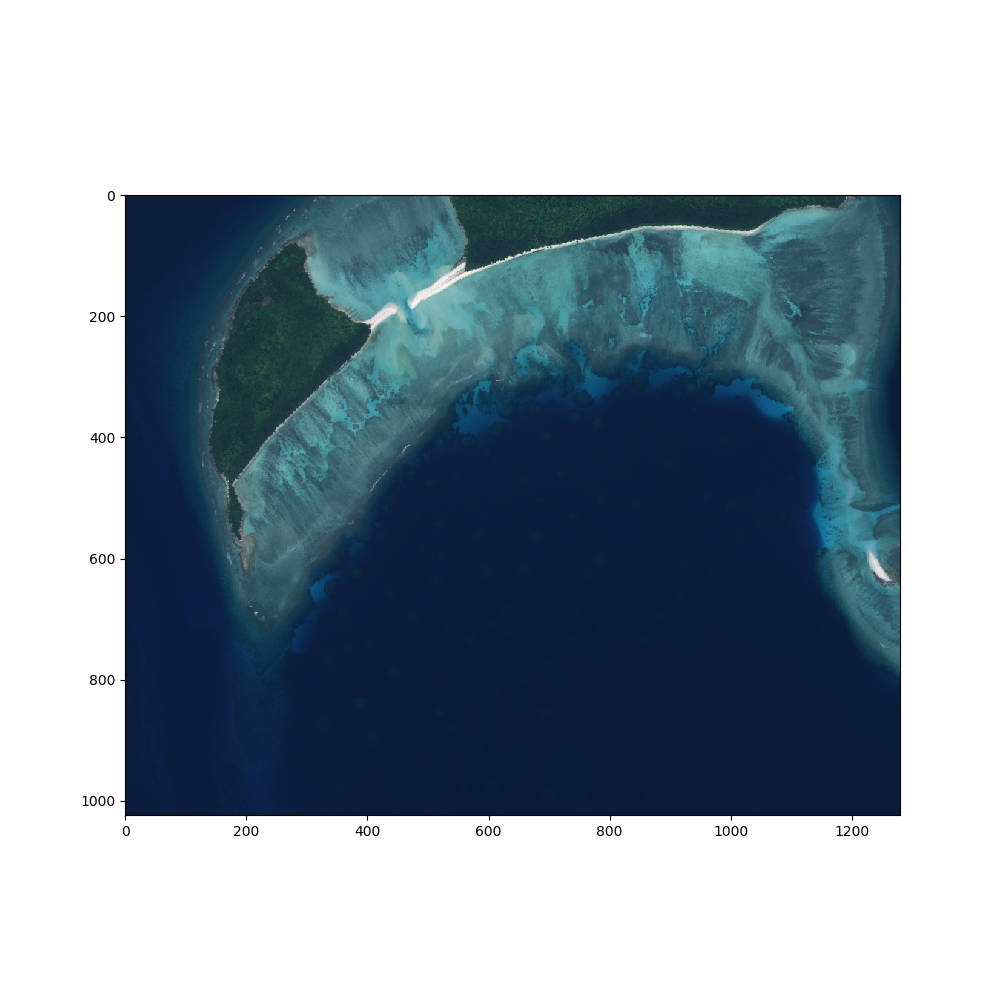

In [4]:
xstart = 500
xlen = 1280
ystart = 500
ylen = 1024

predict_size = x

PerosBanhos.testimage = PerosBanhos.image[ystart:ystart+ylen,xstart:xstart+xlen,:]
crop_len = int(np.floor(x/2))
offstart = crop_len-int(np.floor(predict_size/2))
Testtruth = PerosBanhos.truthimage[ystart+offstart:ystart+ylen-offstart,xstart+offstart:xstart+xlen-offstart]

print(train_generator.class_indices)
max_R = np.max(PerosBanhos.testimage[:,:,4])
max_G = np.max(PerosBanhos.testimage[:,:,2])
max_B = np.max(PerosBanhos.testimage[:,:,1])
Perostest_RGB = np.rollaxis(np.asarray([1/max_R*PerosBanhos.testimage[:,:,4], 1/max_G*PerosBanhos.testimage[:,:,2], 1/max_B*PerosBanhos.testimage[:,:,1]]),0,3)
print(Testtruth.shape)

fig = plt.figure(1,figsize=(10,10))
plt.imshow(Perostest_RGB)
plt.show()

# START PREDICTION

In [5]:
class_indices_rev = dict((v,k) for k,v in train_generator.class_indices.items()) #flip k,v
print(class_indices_rev)

PerosBanhos.set_depth(2047)
print("Total Lines: ", Testtruth.shape[0])
whole_predict, num_predict, prob_predict, truth_predict, accuracy = \
    PerosBanhos.predict_on_whole_image(model, image_size = x, num_classes = len(class_indices_rev), spacing = (64,64), predict_size = predict_size, num_lines=None, lastchannelremove=False)
# for i in range(whole_predict.shape[0]):
#     for j in range(whole_predict.shape[1]):
#         whole_predict[i,j] = train_generator.class_indices[class_indices_rev[whole_predict[i,j]]]
        
accuracy = 100*np.asarray((whole_predict == Testtruth)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print(accuracy)

{0: 'NoData', 1: 'back reef - pavement', 2: 'back reef - rubble dominated', 3: 'back reef - sediment dominated', 4: 'back reef coral framework', 5: 'Beach', 6: 'Clouds', 7: 'coralline algal ridge (reef crest)', 8: 'deep fore reef slope', 9: 'deep lagoonal water', 10: 'deep ocean water', 11: 'dense seagrass meadows', 12: 'fore reef sand flats', 13: 'Inland waters', 14: 'lagoonal floor - barren', 15: 'lagoonal fringing reefs', 16: 'lagoonal patch reefs', 17: 'lagoonal sediment apron - sediment dominated', 18: 'mangroves', 19: 'Rocky beach', 20: 'shallow fore reef slope', 21: 'shallow fore reef terrace', 22: 'terrestrial vegetation', 23: 'Wetlands'}
Total Lines:  1024
88.0121612548828124/ 1025 completed


<IPython.core.display.Javascript object>


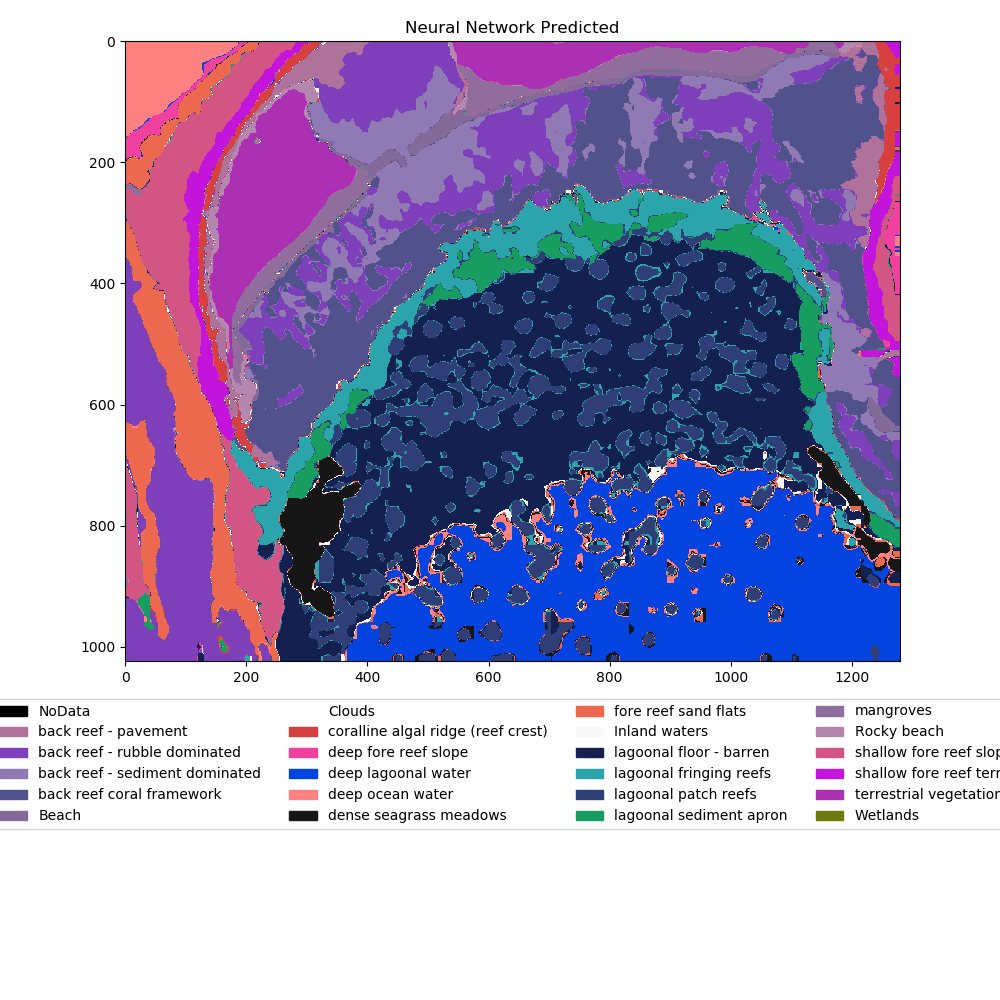

<IPython.core.display.Javascript object>


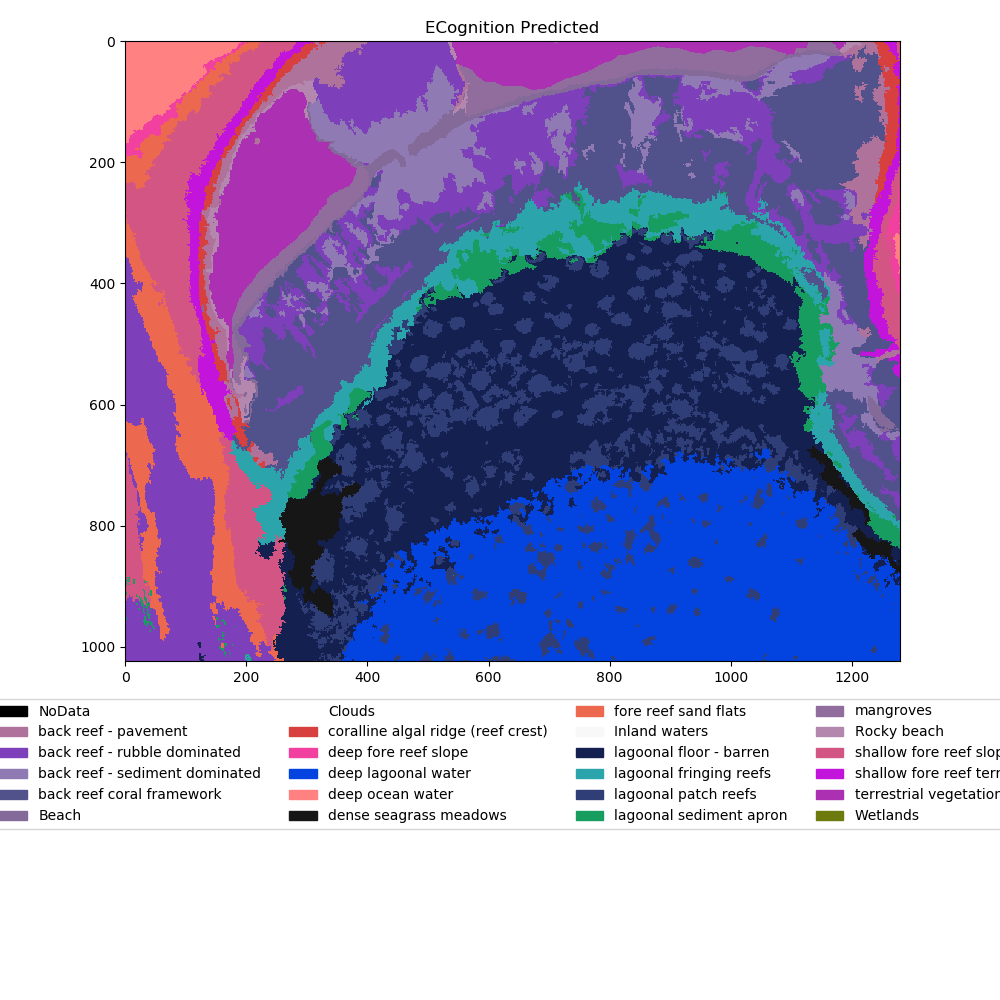

In [6]:
# Colors: 
# NoData: xkcd:black
# back reef - pavement: xkcd:olive
# back reef - rubble dominated: xkcd:slate
# back reef - sediment dominated: xkcd:dirty yellow
# back reef coral framework: xkcd:bluey green
# Beach: xkcd:butter
# Clouds: xkcd:white
# coralline algal ridge (reef crest): xkcd:lilac
# deep fore reef slope: xkcd:cyan
# deep lagoonal water: xkcd:blue
# deep ocean water: xkcd:royal blue
# dense seagrass meadows: xkcd:electric green
# fore reef sand flats: xkcd:caramel
# Inland waters: xkcd:sky blue
# lagoonal floor - barren: xkcd:silver
# lagoonal fringing reefs: xkcd:light orange
# lagoonal patch reef: xkcd:red
# lagoonal sediment apron - sediment dominated: xkcd:dark beige
# mangroves: xkcd:greenish yellow
# Rocky beach: xkcd:sand
# shallow fore reef slope: xkcd:medium pink
# shallow fore reef terrace: xkcd:vibrant purple
# terrestrial vegetation: xkcd:green
# Wetlands: xkcd:murky green
# os.chdir("C:/Users/Rechant/Documents/GitHub/NeMO-NET/CNN")

# np.save("AlexNet_Parallel150_predict.npy", whole_predict)
# np.save("AlexNet_Parallel150_prob.npy", prob_predict)

class_indices_rev[17] = 'lagoonal sediment apron' # manual relabeling (original label is too long)
cmap = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
                             '#846a99', 'xkcd:white', '#d83f3f', '#f140a0', 'xkcd:blue', '#ff8181',
                             '#161616', '#ec684e', '#f8f8f8', '#142050', '#2ca4ab',
                             '#303e77', '#189d60', '#916d9e', '#b487af',
                             '#d35583', '#c214db', '#ab31b2', 'xkcd:murky green'])
bounds = [i-0.5 for i in range(25)]
norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap.N)

fig = plt.figure(2,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(whole_predict.astype(int), interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(24)],
           ['{}'.format(class_indices_rev[i]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=4)
# ax.set_axis_off()
ax.set_title('Neural Network Predicted')
# fig.savefig('Hyperopt_Visualize.png', bbox_inches='tight')


fig = plt.figure(3,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(Testtruth, interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(24)],
           ['{}'.format(class_indices_rev[i]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=4)
ax.set_title('ECognition Predicted')
# ax.set_axis_off()
# fig.savefig('Ecognition_Reference.png', bbox_inches='tight')
plt.show()

# fig = plt.figure(4,figsize=(20,20))
# plt.imshow(Perostest_RGB[crop_len:-crop_len,crop_len:-crop_len,:])
# plt.title('RGB Image')
# plt.axis('off')
# fig.savefig('HyperoptRun_RGB.png', bbox_inches='tight')
# plt.show()

KL-divergence at 0: -10199785.754804691
KL-divergence at 1: -13397877.166418144
KL-divergence at 2: -13500965.998262703
KL-divergence at 3: -13516580.243733753
KL-divergence at 4: -13523608.336059973
KL-divergence at 5: -13528356.860919986
KL-divergence at 6: -13532198.461545154
KL-divergence at 7: -13535460.710747713
KL-divergence at 8: -13538296.62848252
KL-divergence at 9: -13540792.563468246
KL-divergence at 10: -13543012.395858575
KL-divergence at 11: -13545085.475492362
KL-divergence at 12: -13546907.013965603
KL-divergence at 13: -13548668.192138735
KL-divergence at 14: -13550283.289562684
KL-divergence at 15: -13551759.10985577
KL-divergence at 16: -13553060.281571928
KL-divergence at 17: -13554198.472628653
KL-divergence at 18: -13555199.784389414
KL-divergence at 19: -13556118.39065901
Accuracy:  91.56906127929688


<IPython.core.display.Javascript object>


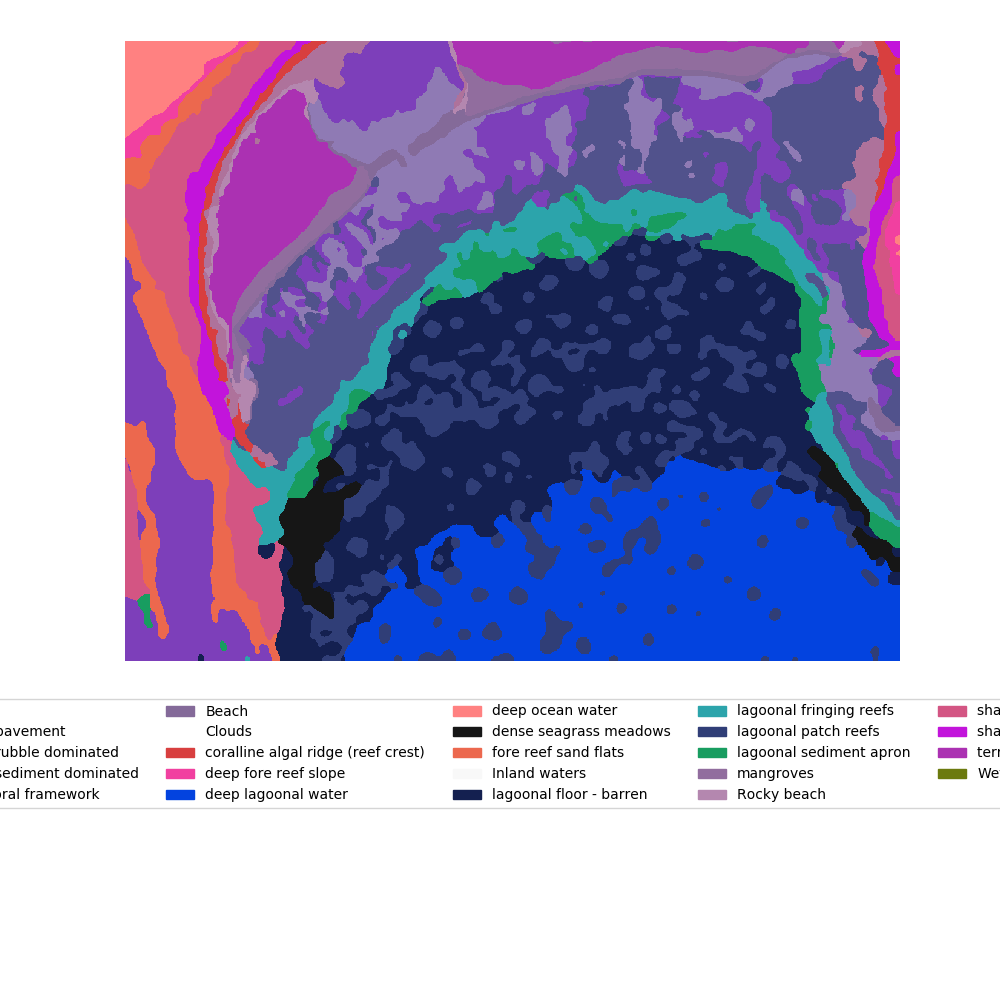

In [7]:
# Conditional random field code
import pydensecrf.densecrf as dcrf
from cv2 import imread, imwrite
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian, unary_from_softmax

prob_predict_switch = np.rollaxis(prob_predict,2,0)
U = unary_from_softmax(prob_predict_switch, scale=0.9, clip=1e-5)
d = dcrf.DenseCRF2D(whole_predict.shape[1], whole_predict.shape[0],len(class_indices_rev))
d.setUnaryEnergy(U)
pairwise_gaussian = create_pairwise_gaussian(sdims=(3, 3), shape=whole_predict.shape[:2])
d.addPairwiseEnergy(pairwise_gaussian, compat=3, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)
stddevs = np.asarray([204., 123., 150., 134., 58., 104., 92., 120.])
pairwise_bilateral = create_pairwise_bilateral(sdims=(1, 1), schan=stddevs, img=PerosBanhos.testimage, chdim=2)
d.addPairwiseEnergy(pairwise_bilateral, compat=8, kernel=dcrf.DIAG_KERNEL, normalization=dcrf.NORMALIZE_SYMMETRIC)

Q, tmp1, tmp2 = d.startInference()
for i in range(20):
    print("KL-divergence at {}: {}".format(i, d.klDivergence(Q)))
    d.stepInference(Q, tmp1, tmp2)

MAP = np.argmax(Q, axis=0)
final_predict = np.reshape(MAP, (whole_predict.shape[0], whole_predict.shape[1]))
accuracy = 100*np.asarray((final_predict == Testtruth)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])
print("Accuracy: ", accuracy)

fig = plt.figure(5,figsize=(10,10))
ax = plt.subplot(111)
ax.imshow(final_predict, interpolation='nearest', cmap=cmap, norm=norm)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.2,
                 box.width, box.height])
ax.legend([mpatches.Patch(color=cmap(i)) for i in range(len(class_indices_rev))],
           ['{}'.format(class_indices_rev[i]) for i in range(len(class_indices_rev))],
          loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=5)
ax.set_axis_off()
plt.show()

./utils\loadcoraldata_utils.py:560: RuntimeWarning: invalid value encountered in true_divide
  if normalize:


Normalized confusion matrix
0.5


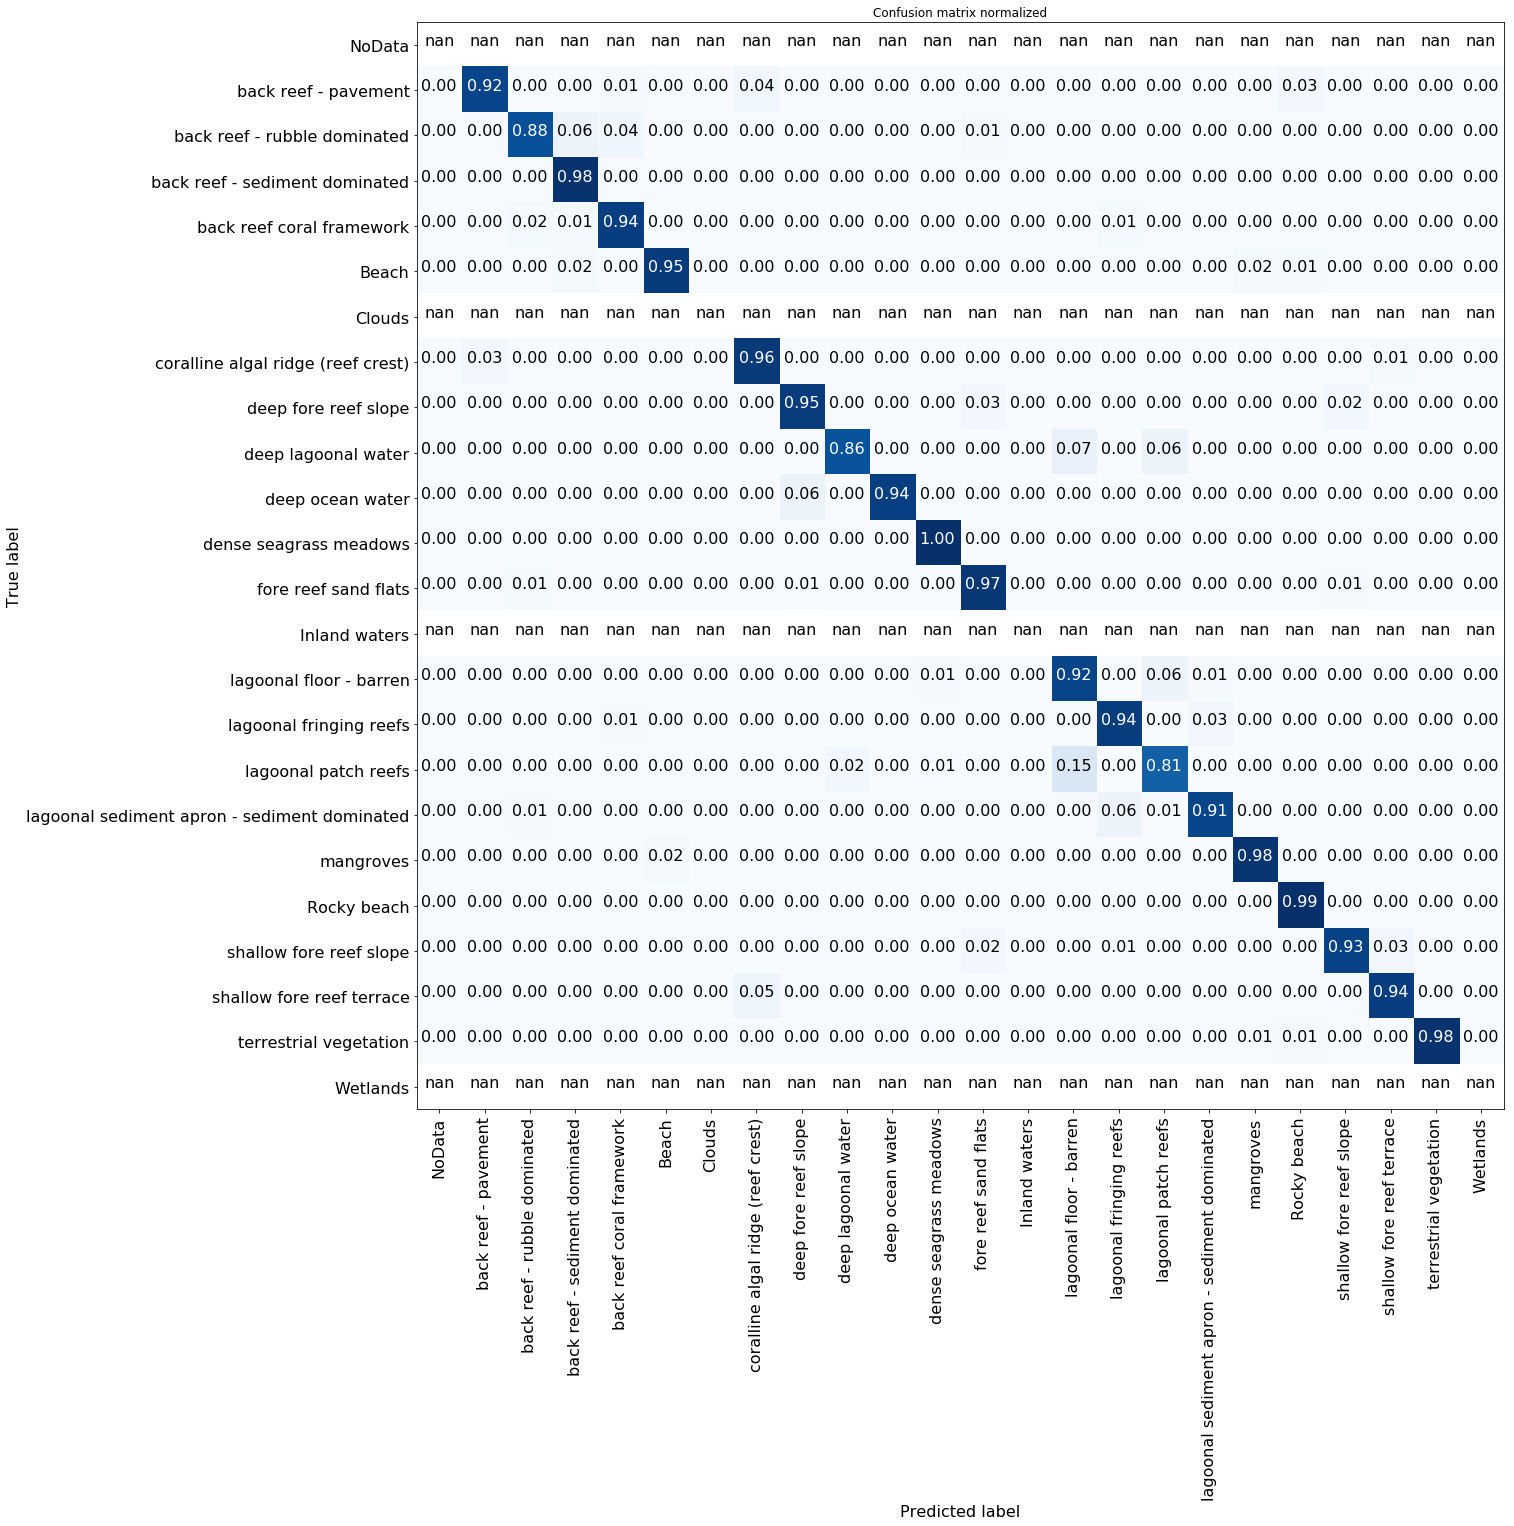

In [48]:
from sklearn.metrics import confusion_matrix
from importlib import reload
reload(coralutils)

cm = confusion_matrix(Testtruth.flatten(), final_predict.flatten(), labels=range(24))
coralutils.plot_confusion_matrix(cm, PerosBanhos.class_labels, normalize=True)


In [4]:
# Visualization run across learning process (every 50 batches)
class_indices_rev = dict((v,k) for k,v in train_generator.class_indices.items()) #flip k,v
print(class_indices_rev)
PerosBanhos.set_depth(2047)
print("Total Lines: ", Testtruth.shape[0])

os.chdir("C:/Users/asli/Documents/GitHub/NeMO-NET/CNN/weights")
counter = 0
startcounter = 231
for file in glob.glob("*.hdf5"):
    file_str = file[8:-5]
    if counter >= startcounter and counter%4==0:
        print(file_str)
        model.load_weights(file)
        whole_predict, num_predict, truth_predict, accuracy = PerosBanhos.predict_on_whole_image(model, image_size = x, num_lines=None, lastchannelremove=False)
        accuracy = 100*np.asarray((whole_predict == Testtruth)).astype(np.float32).sum()/(whole_predict.shape[0]*whole_predict.shape[1])

        outfile = file_str + '.npy'
        np.save(outfile,whole_predict)

        class_indices_rev[17] = 'lagoonal sediment apron' # manual relabeling (original label is too long)
        cmap = colors.ListedColormap(['xkcd:black', '#ae729b', '#7d3fba', '#8f7ab4', '#51528c',
                                 '#846a99', 'xkcd:white', '#d83f3f', '#f140a0', 'xkcd:blue', '#ff8181',
                                 '#161616', '#ec684e', '#f8f8f8', '#142050', '#2ca4ab',
                                 '#303e77', '#189d60', '#916d9e', '#b487af',
                                 '#d35583', '#c214db', '#ab31b2', 'xkcd:murky green'])
        bounds = [i-0.5 for i in range(25)]
        norm = colors.BoundaryNorm([b+0.5 for b in bounds], cmap.N)

        fig = plt.figure(5,figsize=(20,20))
        ax = plt.subplot(111)
        ax.imshow(whole_predict, interpolation='nearest', cmap=cmap, norm=norm)
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.2,
                         box.width, box.height])
        ax.legend([mpatches.Patch(color=cmap(i)) for i in range(24)],
                   ['{}'.format(class_indices_rev[i]) for i in range(len(class_indices_rev))],
                  loc='upper center', bbox_to_anchor=(0.5,-0.05), ncol=3)
        ax.set_axis_off()
        ax.set_title('Neural Network Predicted')
        fig.savefig(file_str + '.png', bbox_inches='tight')

        filename = './temp_saveacc.txt'
        if counter == 0:
            f = open(filename,"w")
        else:
            f = open(filename,"a")
        f.write("%.6f \n" %accuracy)
        f.close()
    counter += 1

{0: 'NoData', 1: 'back reef - pavement', 2: 'back reef - rubble dominated', 3: 'back reef - sediment dominated', 4: 'back reef coral framework', 5: 'Beach', 6: 'Clouds', 7: 'coralline algal ridge (reef crest)', 8: 'deep fore reef slope', 9: 'deep lagoonal water', 10: 'deep ocean water', 11: 'dense seagrass meadows', 12: 'fore reef sand flats', 13: 'Inland waters', 14: 'lagoonal floor - barren', 15: 'lagoonal fringing reefs', 16: 'lagoonal patch reefs', 17: 'lagoonal sediment apron - sediment dominated', 18: 'mangroves', 19: 'Rocky beach', 20: 'shallow fore reef slope', 21: 'shallow fore reef terrace', 22: 'terrestrial vegetation', 23: 'Wetlands'}
Total Lines:  351
NeMO_AlexNetParallel_epoch058_batch11600
NeMO_AlexNetParallel_epoch059_batch11800


c:\program files\python36\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


NeMO_AlexNetParallel_epoch060_batch12000
NeMO_AlexNetParallel_epoch061_batch12200
NeMO_AlexNetParallel_epoch062_batch12400
NeMO_AlexNetParallel_epoch063_batch12600
NeMO_AlexNetParallel_epoch064_batch12800
NeMO_AlexNetParallel_epoch065_batch13000
NeMO_AlexNetParallel_epoch066_batch13200
NeMO_AlexNetParallel_epoch067_batch13400
NeMO_AlexNetParallel_epoch068_batch13600
NeMO_AlexNetParallel_epoch069_batch13800
NeMO_AlexNetParallel_epoch070_batch14000
NeMO_AlexNetParallel_epoch071_batch14200
NeMO_AlexNetParallel_epoch072_batch14400
NeMO_AlexNetParallel_epoch073_batch14600
NeMO_AlexNetParallel_epoch074_batch14800
NeMO_AlexNetParallel_epoch075_batch15000
NeMO_AlexNetParallel_epoch076_batch15200
NeMO_AlexNetParallel_epoch077_batch15400
NeMO_AlexNetParallel_epoch078_batch15600
NeMO_AlexNetParallel_epoch079_batch15800
NeMO_AlexNetParallel_epoch080_batch16000
NeMO_AlexNetParallel_epoch081_batch16200
NeMO_AlexNetParallel_epoch082_batch16400
NeMO_AlexNetParallel_epoch083_batch16600
NeMO_AlexNetPara